In [14]:
def dailyposition(ticker, strike , vol , ticker_hedge, strikeh, volh , date, maturity ):
    import yfinance as yf
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from scipy.stats import norm

    def estimates(ticker, strike, vol, enddata, expiration):


        # Function to calculate Black-Scholes Greeks
        def black_scholes_greeks(S, K, T, r, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            delta = norm.cdf(d1)
            gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
            theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d1)
            return call_price, delta, gamma, theta

        # Fetch historical stock prices for AAPL
        stock_data = yf.download(ticker, start='2023-01-01', end=enddata)

        
        # Extract the 'Close' prices and convert index to datetime
        stock_prices = stock_data['Close']
        stock_volu = stock_data['Volume']
        stock_prices.index = pd.to_datetime(stock_prices.index)

        # Define option parameters
        K = strike  # Strike price of the option
        r = 0.01  # Risk-free interest rate
        sigma = vol # Volatility of the underlying stock

        # Initialize lists to store values
        option_prices = []
        delta_values = []
        gamma_values = []
        theta_values = []

        for date in stock_prices.index:
            # Calculate time to expiration dynamically
            T = (pd.Timestamp(expiration) - date).days / 365

            # Get the corresponding stock price
            S = stock_prices.loc[date]

            # Calculate option price and Greeks
            call_price, delta, gamma, theta = black_scholes_greeks(S, K, T, r, sigma)

            # Append to lists
            option_prices.append(call_price)
            delta_values.append(delta)
            gamma_values.append(gamma)
            theta_values.append(theta)



        stock_data['Volume'] = stock_data['Volume'] / 1000000
        

        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error

        maturity_date = pd.Timestamp(expiration)


        opp = pd.DataFrame({'OPrice': option_prices})
        delt = pd.DataFrame({'Delta': delta_values})
        gam = pd.DataFrame({'Gamma': gamma_values})
        thet = pd.DataFrame({'Theta': theta_values})


        df = pd.concat([ opp, delt, gam, thet], axis=1)
        df.set_index(stock_data.index, inplace=True)
        df['volu']=stock_data['Volume']
        df['precio']=stock_data['Close']
        df['time_to_maturity'] = (maturity_date - df.index).days / 365


        df['lggamma'] = df['Gamma'].shift(1)
        df['lgdelta'] = df['Delta'].shift(1)
        df['lgprice'] = df['OPrice'].shift(1)
        df['lgtheta'] = df['Theta'].shift(1)
        df['lgvolu'] = df['volu'].shift(1)
        df['lgprix'] = df['precio'].shift(1)

        df['lggamma2'] = df['Gamma'].shift(2)
        df['lgdelta2'] = df['Delta'].shift(2)
        df['lgprice2'] = df['OPrice'].shift(2)
        df['lgtheta2'] = df['Theta'].shift(2)
        df['lgvolu2'] = df['volu'].shift(2)
        df['lgprix2'] = df['precio'].shift(2)

        

        df['lngamma'] = np.log(df['Gamma'])




        df['lnlggamma'] = np.log(df['lggamma'])
        df['lnlgvolu'] = np.log(df['lgvolu'])
        df['lnlggamma2'] = np.log(df['lggamma2'])
        df['lnlgvolu2'] = np.log(df['lgvolu2'])



        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import r2_score
        import statsmodels.api as sm



        df = df.dropna()
        df['lnt'] = np.log(df['time_to_maturity'])
        X = df[['lnlggamma', 'lnt', 'lgprice', 'lgprix', 'lgdelta', 'lgtheta', 'lgprix2']]
        y = df['lngamma']
        df.to_excel('output10.xlsx', index=True)

        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        n = len(X)
        split_index = int(n * 0.9)
        X_train = X.iloc[:split_index]
        y_train = y.iloc[:split_index]
        X_test = X.iloc[split_index:]
        y_test = y.iloc[split_index:]



        # Function to fit a model and return AIC, BIC, and R²
        def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
            model_sm = sm.OLS(y_train, X_train_sm).fit()
            aic = model_sm.aic
            bic = model_sm.bic
            return aic, bic, r2

        # Initial model with all features
        initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
        #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

        # Evaluate models by removing one feature at a time
        results = []
        for feature in X.columns:
            X_train_reduced = X_train.drop(columns=[feature])
            X_test_reduced = X_test.drop(columns=[feature])
            aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
            results.append((feature, aic, bic, r2))

        # Find the best model based on AIC, BIC, and R²
        best_aic = min(results, key=lambda x: x[1])
        best_bic = min(results, key=lambda x: x[2])
        best_r2 = max(results, key=lambda x: x[3])

        #print("\nBest model results after removing one feature:")
        #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
        #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
        #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

        #X = X.drop(columns=['lgdelta'])

        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X = X.drop(columns=['lgprice'])
        X_train = X_train.drop(columns=['lgprice'])
        X_test = X_test.drop(columns=['lgprice'])


        # Function to fit a model and return AIC, BIC, and R²
        def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
            model_sm = sm.OLS(y_train, X_train_sm).fit()
            aic = model_sm.aic
            bic = model_sm.bic
            return aic, bic, r2

        # Initial model with all features
        initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
        #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

        # Evaluate models by removing one feature at a time
        results = []
        for feature in X.columns:
            X_train_reduced = X_train.drop(columns=[feature])
            X_test_reduced = X_test.drop(columns=[feature])
            aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
            results.append((feature, aic, bic, r2))

        # Find the best model based on AIC, BIC, and R²
        best_aic = min(results, key=lambda x: x[1])
        best_bic = min(results, key=lambda x: x[2])
        best_r2 = max(results, key=lambda x: x[3])

        #print("\nBest model results after removing one feature:")
        #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
        #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
        #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

        #print(X)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X = X.drop(columns=['lgprix2'])
        X_train = X_train.drop(columns=['lgprix2'])
        X_test = X_test.drop(columns=['lgprix2'])


        # Function to fit a model and return AIC, BIC, and R²
        def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
            model_sm = sm.OLS(y_train, X_train_sm).fit()
            aic = model_sm.aic
            bic = model_sm.bic
            return aic, bic, r2

        # Initial model with all features
        initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
        #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

        # Evaluate models by removing one feature at a time
        results = []
        for feature in X.columns:
            X_train_reduced = X_train.drop(columns=[feature])
            X_test_reduced = X_test.drop(columns=[feature])
            aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
            results.append((feature, aic, bic, r2))

        # Find the best model based on AIC, BIC, and R²
        best_aic = min(results, key=lambda x: x[1])
        best_bic = min(results, key=lambda x: x[2])
        best_r2 = max(results, key=lambda x: x[3])

        #print("\nBest model results after removing one feature:")
        #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
        #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
        #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

        #X = X.drop(columns=['lgprice'])
    #print(X)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X = X.drop(columns=['lgdelta'])
        X_train = X_train.drop(columns=['lgdelta'])
        X_test = X_test.drop(columns=['lgdelta'])


        # Function to fit a model and return AIC, BIC, and R²
        def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
            model_sm = sm.OLS(y_train, X_train_sm).fit()
            aic = model_sm.aic
            bic = model_sm.bic
            return aic, bic, r2

        # Initial model with all features
        initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
        #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

        # Evaluate models by removing one feature at a time
        results = []
        for feature in X.columns:
            X_train_reduced = X_train.drop(columns=[feature])
            X_test_reduced = X_test.drop(columns=[feature])
            aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
            results.append((feature, aic, bic, r2))

        # Find the best model based on AIC, BIC, and R²
        best_aic = min(results, key=lambda x: x[1])
        best_bic = min(results, key=lambda x: x[2])
        best_r2 = max(results, key=lambda x: x[3])


        X = X.drop(columns=['lgprix'])
        X_train = X_train.drop(columns=['lgprix'])
        X_test = X_test.drop(columns=['lgprix'])


        # Function to fit a model and return AIC, BIC, and R²
        def fit_model_and_evaluate(X_train, y_train, X_test, y_test, showpvalues):
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fitted_values = model.predict(X_train)
            r2 = r2_score(y_test, y_pred)

            X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
            model_sm = sm.OLS(y_train, X_train_sm).fit()
            aic = model_sm.aic
            bic = model_sm.bic
            sigma_hat = np.sqrt(model_sm.mse_resid)
            #print("SIGMA HAT = ", sigma_hat)  
            residuals = y_test - y_pred
            residualstrain = y_train - fitted_values
            if showpvalues:
                pvalues = model_sm.pvalues
                print(pvalues)
                plt.figure(figsize=(12, 8))
                for i, feature in enumerate(X_train.columns):
                    plt.subplot(2, 2, i+1)
                    plt.scatter(X_train[feature], residualstrain)
                    plt.axhline(y=0, color='r', linestyle='--')
                    plt.xlabel(feature)
                    plt.ylabel('Residuals')
                    plt.title(f'Residuals vs {feature}')
                    plt.tight_layout(pad=3.0)
                plt.figure(figsize=(11, 7))
                plt.scatter(fitted_values, residualstrain)
                plt.xlabel('Fitted values')
                plt.ylabel('Residuals')
                plt.title(f'Residuals vs fitted values')

            coefs = list()
            coefs.append(model.intercept_)
            #print(model.intercept_)    
            #print("Regression Coefficients:")
            for feature, coef in zip(X_train.columns, model.coef_):
                #print(f"{feature}: {coef}")
                coefs.append(coef)



            return aic, bic, r2, coefs, sigma_hat

        # Initial model with all features
        initial_aic, initial_bic, initial_r2, coefs, sigma_hat = fit_model_and_evaluate(X_train, y_train, X_test, y_test, False)
        #print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

        # Evaluate models by removing one feature at a time
        results = []
        for feature in X.columns:
            X_train_reduced = X_train.drop(columns=[feature])
            X_test_reduced = X_test.drop(columns=[feature])
            aic, bic, r2, _ , _ = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test, False)
            results.append((feature, aic, bic, r2))

        # Find the best model based on AIC, BIC, and R²
        best_aic = min(results, key=lambda x: x[1])
        best_bic = min(results, key=lambda x: x[2])
        best_r2 = max(results, key=lambda x: x[3])

        #print("\nBest model results after removing one feature:")
        #print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
        #print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
        #print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")



        return coefs, sigma_hat, df.iloc[-1]
    
    coefs, sigma_hat, lastday = estimates(ticker, strike, vol, date, maturity)

    import math

    maturity_date = pd.Timestamp(maturity)
    time = (maturity_date - pd.Timestamp(date)).days / 365
    lgtime=math.log(time)

    x_aapl = coefs[0]+coefs[1]*lastday['lngamma']+coefs[2]*lgtime+coefs[3]*lastday['Theta']
    gamma_aapl_pred=math.exp(x_aapl)*math.exp(sigma_hat*sigma_hat/2)
    gamma_aapl_prev = lastday['Gamma']
    delta_aapl_prev = lastday['Delta']

    coefs, sigma_hat, lastday = estimates(ticker_hedge, strikeh, volh, date, maturity)

    x_msft = coefs[0]+coefs[1]*lastday['lngamma']+coefs[2]*lgtime+coefs[3]*lastday['Theta']
    gamma_msft_pred=math.exp(x_msft)*math.exp(sigma_hat*sigma_hat/2)
    gamma_msft_prev = lastday['Gamma']
    delta_msft_prev = lastday['Delta']

    #print(gamma_aapl_pred, gamma_aapl_prev, gamma_msft_pred, gamma_msft_prev)
    
    from datetime import datetime, timedelta

    date_obj = datetime.strptime(date, '%Y-%m-%d')
    previous_day = date_obj - timedelta(days=1)
    previous_day_str = previous_day.strftime('%Y-%m-%d')

    stock_data = yf.download(ticker, start=previous_day_str, end=date)
    S= stock_data['Close']

    def speed(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        speed = - ( norm.pdf(d1)) / (S**2 * sigma * np.sqrt(T)) * (d1 / (sigma * np.sqrt(T)) + 1)

        return speed

    speed_aapl = speed(S, strike, (pd.Timestamp(maturity) - pd.Timestamp(previous_day_str)).days / 365, 0.01, vol)
    stock_data = yf.download(ticker_hedge, start=previous_day_str, end=date)
    S= stock_data['Close']
    speed_msft = speed(S, strikeh, (pd.Timestamp(maturity) - pd.Timestamp(previous_day_str)).days / 365, 0.01, volh)

    delta_aapl_pred= delta_aapl_prev+ gamma_aapl_pred * (gamma_aapl_pred - gamma_aapl_prev) / speed_aapl
    delta_msft_pred= delta_msft_prev+ gamma_msft_pred * (gamma_msft_pred - gamma_msft_prev) / speed_msft
    delta_aapl_pred=delta_aapl_pred.iloc[0]
    delta_msft_pred=delta_msft_pred.iloc[0]

    
    a1, b1, c1 = 1, delta_msft_pred, -delta_aapl_pred
    a2, b2, c2 = 0, gamma_msft_pred, -gamma_aapl_pred

    A = np.array([[a1, b1], [a2, b2]])
    b = np.array([c1, c2])

    positions = np.linalg.solve(A, b)

    stock_position, msft_position = positions

    print(f"For the {date}, you should hold: {stock_position*100} shares of {ticker} stocks and {msft_position*100} {ticker_hedge} call options with the strike and maturity abovementionned")
    
    
    return stock_position, msft_position

We finally move on to delta-gamma hedging over a longer period of time. Below you can put the day at which you want to start hedging your call options from stock X of volatility V1 with strike K1 and maturity T and precising the options you want to use for hedging i.e. call options from a stock Y of volatility V2 with strike K2 and same maturity. 

An example is given below, starting 16th April 2024, with call options from Apple stock with strike 185 and maturity 04th June 2024, hedged with call options of Microsoft stock with strike 410. Volatility details and examples of strike prices can be found either on a excel given of on Yahoo Finance. Suppose you want to hedge the options until the 23rd May.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-16, you should hold: 52.83929701251101 shares of AAPL stocks and -155.7225601985587 MSFT call options with the strike and maturity abovementionned
2024-04-16


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-17, you should hold: 53.13503746505916 shares of AAPL stocks and -140.48304260932304 MSFT call options with the strike and maturity abovementionned
2024-04-17


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-18, you should hold: 43.44176938182478 shares of AAPL stocks and -129.47919076552722 MSFT call options with the strike and maturity abovementionned
2024-04-18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-19, you should hold: 61.117721558426986 shares of AAPL stocks and -120.69237002448257 MSFT call options with the strike and maturity abovementionned
2024-04-19


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-20, you should hold: 32.93193599968687 shares of AAPL stocks and -109.1640646805462 MSFT call options with the strike and maturity abovementionned
2024-04-20


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-23, you should hold: 36.447605272696734 shares of AAPL stocks and -107.83821593309129 MSFT call options with the strike and maturity abovementionned
2024-04-23


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-24, you should hold: 4.609023323405186 shares of AAPL stocks and -110.81608807247088 MSFT call options with the strike and maturity abovementionned
2024-04-24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-25, you should hold: 27.194853194995872 shares of AAPL stocks and -122.75106074001113 MSFT call options with the strike and maturity abovementionned
2024-04-25


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-26, you should hold: 35.13083984114303 shares of AAPL stocks and -130.56678702166244 MSFT call options with the strike and maturity abovementionned
2024-04-26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-27, you should hold: 183.34463490534986 shares of AAPL stocks and -122.17000539575649 MSFT call options with the strike and maturity abovementionned
2024-04-27


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-04-30, you should hold: 44.193647025250485 shares of AAPL stocks and -144.59466125019944 MSFT call options with the strike and maturity abovementionned
2024-04-30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-01, you should hold: 19.53694251062362 shares of AAPL stocks and -151.1941107248725 MSFT call options with the strike and maturity abovementionned
2024-05-01


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-02, you should hold: 24.880308525217142 shares of AAPL stocks and -125.78270293275781 MSFT call options with the strike and maturity abovementionned
2024-05-02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-03, you should hold: 30.530663224611875 shares of AAPL stocks and -145.64133642623435 MSFT call options with the strike and maturity abovementionned
2024-05-03


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-04, you should hold: 84.39949799238514 shares of AAPL stocks and -166.38310931525191 MSFT call options with the strike and maturity abovementionned
2024-05-04


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-07, you should hold: 53.00605970797459 shares of AAPL stocks and -170.25176386989622 MSFT call options with the strike and maturity abovementionned
2024-05-07


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-08, you should hold: 27.770111092940265 shares of AAPL stocks and -166.52957492691718 MSFT call options with the strike and maturity abovementionned
2024-05-08


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-09, you should hold: 48.02698557932929 shares of AAPL stocks and -167.90712034646845 MSFT call options with the strike and maturity abovementionned
2024-05-09


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-10, you should hold: 23.753559364842204 shares of AAPL stocks and -168.67758735816665 MSFT call options with the strike and maturity abovementionned
2024-05-10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-11, you should hold: 86.80051909551005 shares of AAPL stocks and -173.42096975972387 MSFT call options with the strike and maturity abovementionned
2024-05-11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-14, you should hold: 29.21523204507056 shares of AAPL stocks and -166.33643511703815 MSFT call options with the strike and maturity abovementionned
2024-05-14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-15, you should hold: 39.70649622215349 shares of AAPL stocks and -169.34304671187195 MSFT call options with the strike and maturity abovementionned
2024-05-15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-16, you should hold: 66.97291920871511 shares of AAPL stocks and -186.15793276611038 MSFT call options with the strike and maturity abovementionned
2024-05-16


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-17, you should hold: 51.80005561961245 shares of AAPL stocks and -173.72708593511157 MSFT call options with the strike and maturity abovementionned
2024-05-17


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-18, you should hold: 47.18638598912443 shares of AAPL stocks and -169.97354199782862 MSFT call options with the strike and maturity abovementionned
2024-05-18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-21, you should hold: 82.4650254455608 shares of AAPL stocks and -197.35227819726953 MSFT call options with the strike and maturity abovementionned
2024-05-21


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-22, you should hold: 113.33615712288689 shares of AAPL stocks and -224.53036230696605 MSFT call options with the strike and maturity abovementionned
2024-05-22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For the 2024-05-23, you should hold: 170.16726030416802 shares of AAPL stocks and -279.0651062873244 MSFT call options with the strike and maturity abovementionned
2024-05-23


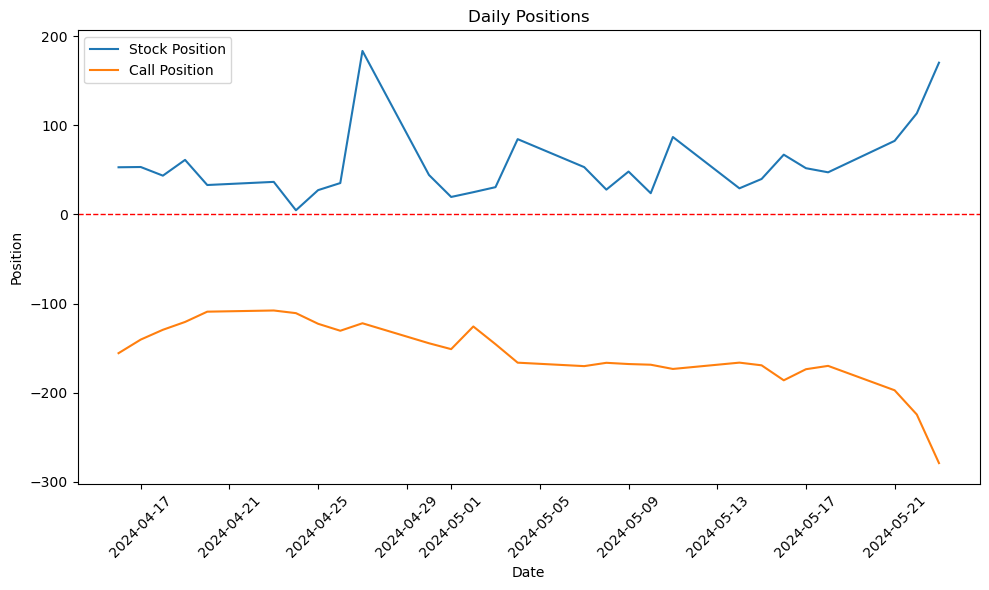

In [26]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
start_date_str = '2024-04-16'
end_date_str = '2024-05-23'
maturity= '2024-06-04'
initial_stock = 'AAPL'
initial_strike = 185
initial_vol = 0.2702

hedging_stock = 'MSFT'
hedging_strike = 410
hedging_vol = 0.2119


start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

dates = []
stock_positions = []
call_positions = []

current_date = start_date
while current_date <= end_date:
    # Check if the current date is a Saturday or Sunday
    if current_date.weekday() in [6, 0]:  # 6: Sunday, 0: Monday
        # Skip Sunday or Monday
        current_date += timedelta(days=1)
        continue
    # Calculate daily positions
    sp, cp = dailyposition(initial_stock, initial_strike, initial_vol, hedging_stock, hedging_strike, hedging_vol, current_date.strftime('%Y-%m-%d'), maturity)
    
    # Store the date and positions
    dates.append(current_date)
    stock_positions.append(sp*100)
    call_positions.append(cp*100)
    
    # Print the current date
    print(current_date.strftime('%Y-%m-%d'))
    
    # Move to the next day
    current_date += timedelta(days=1)

# Plot the positions against the dates
plt.figure(figsize=(10, 6))
plt.plot(dates, stock_positions, label='Stock Position')
plt.plot(dates, call_positions, label='Call Position')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)  
plt.xlabel('Date')
plt.ylabel('Position')
plt.title('Daily Positions')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
    
    
